In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette(sns.color_palette("tab10", 8))

In [85]:
len(throws)

10000000

In [88]:
def simulate_dice_throws(dice_n_faces=6, n_simultaneous_throws=6, n_simulations = 10000000):
    simulated_throws = np.random.randint(low = 1, high = dice_n_faces+1, 
                                         size=(n_simulations,n_simultaneous_throws))
    throws = pd.DataFrame(simulated_throws)

    return throws

def prob_at_least_1_higher_than(throws, dice_n_faces=6, n_simultaneous_throws=6):
    n_simulations = len(throws)
    my_probs ={}
    final_results = pd.DataFrame()
    aggregated_results = []
    empty_col = np.full((n_simulations, 1), False)

    for i_n_simultaneous_throws in np.arange(1,n_simultaneous_throws):
        for i_threshold in np.arange(1,dice_n_faces+1):
            temp_results = {}

            tt = throws >= i_threshold
            tt['results'] = empty_col

            for i_throw_n in np.arange(0, i_n_simultaneous_throws): 
                tt['results'] = tt[i_throw_n] | tt['results']

            my_prob = sum(tt['results'])/len(tt['results'])

            temp_results['dice_n'] = i_n_simultaneous_throws
            temp_results['i_threshold'] = i_threshold
            temp_results['prob'] = my_prob

            aggregated_results.append(temp_results)
            
    results_df = pd.DataFrame(aggregated_results)        
    return results_df

Text(0.5, 1.0, 'P of rolling at least 1 die >= i_threshold, depending on n dice rolled')

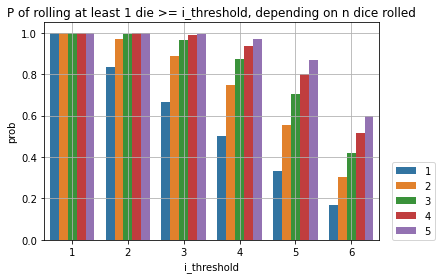

In [79]:
dice_n_faces=4

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              n_simultaneous_throws=dice_n_faces)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         n_simultaneous_throws=dice_n_faces)

results_df = pd.DataFrame(aggregated_results)
ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0))
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled')

In [80]:
dice_n_faces = 8
n_simultaneous_throws = 8
n_simulations = 10000000
simulated_throws = np.random.randint(low = 1, high = dice_n_faces+1, 
                                     size=(n_simulations,n_simultaneous_throws))
throws = pd.DataFrame(simulated_throws)

my_probs ={}
final_results = pd.DataFrame()
aggregated_results = []
empty_col = np.full((n_simulations, 1), False)

for i_n_simultaneous_throws in np.arange(1,n_simultaneous_throws):
    for i_threshold in np.arange(1,dice_n_faces+1):
        temp_results = {}

        tt = throws >= i_threshold
        tt['results'] = empty_col
        
        for i_throw_n in np.arange(0, i_n_simultaneous_throws): 
            tt['results'] = tt[i_throw_n] | tt['results']
            
        my_prob = sum(tt['results'])/len(tt['results'])
        
        temp_results['dice_n'] = i_n_simultaneous_throws
        temp_results['i_threshold'] = i_threshold
        temp_results['prob'] = my_prob
        
        aggregated_results.append(temp_results)

Text(0.5, 1.0, 'P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d8)')

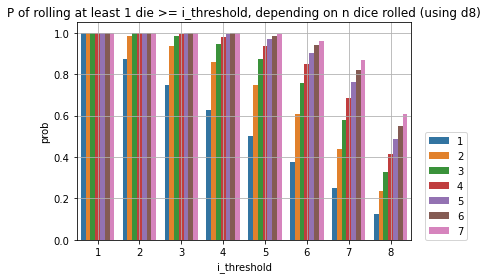

In [81]:
results_df = pd.DataFrame(aggregated_results)
ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0))
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d'+str(dice_n_faces)+')')

In [82]:
dice_n_faces = 4
n_simultaneous_throws = 4
n_simulations = 10000000
simulated_throws = np.random.randint(low = 1, high = dice_n_faces+1, 
                                     size=(n_simulations,n_simultaneous_throws))
throws = pd.DataFrame(simulated_throws)

my_probs ={}
final_results = pd.DataFrame()
aggregated_results = []
empty_col = np.full((n_simulations, 1), False)

for i_n_simultaneous_throws in np.arange(1,n_simultaneous_throws):
    for i_threshold in np.arange(1,dice_n_faces+1):
        temp_results = {}

        tt = throws >= i_threshold
        tt['results'] = empty_col
        
        for i_throw_n in np.arange(0, i_n_simultaneous_throws): 
            tt['results'] = tt[i_throw_n] | tt['results']
            
        my_prob = sum(tt['results'])/len(tt['results'])
        
        temp_results['dice_n'] = i_n_simultaneous_throws
        temp_results['i_threshold'] = i_threshold
        temp_results['prob'] = my_prob
        
        aggregated_results.append(temp_results)

Text(0.5, 1.0, 'P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d4)')

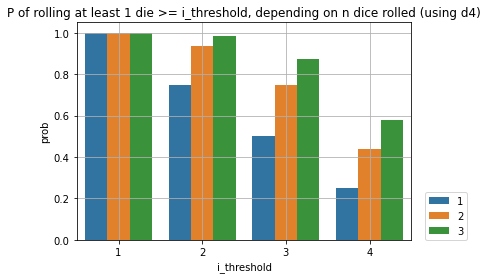

In [83]:
results_df = pd.DataFrame(aggregated_results)
ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0))
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d'+str(dice_n_faces)+')')

Text(0.5, 1.0, 'P of rolling at least 1 die >= i_threshold, depending on n dice rolled')

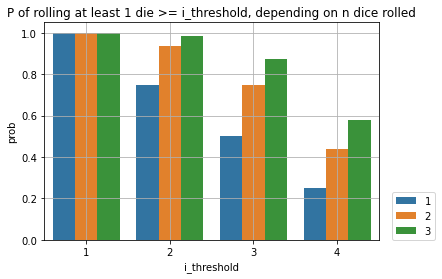

In [89]:
dice_n_faces=4

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              n_simultaneous_throws=dice_n_faces)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         n_simultaneous_throws=dice_n_faces)

results_df = pd.DataFrame(aggregated_results)
ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0))
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d'+str(dice_n_faces)+')')

In [ ]:
dice_n_faces=6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              n_simultaneous_throws=dice_n_faces)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         n_simultaneous_throws=dice_n_faces)

results_df = pd.DataFrame(aggregated_results)
ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0))
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d'+str(dice_n_faces)+')')

In [ ]:
dice_n_faces=8

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              n_simultaneous_throws=dice_n_faces)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         n_simultaneous_throws=dice_n_faces)

results_df = pd.DataFrame(aggregated_results)
ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0))
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d'+str(dice_n_faces)+')')

In [ ]:
dice_n_faces=12

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              n_simultaneous_throws=dice_n_faces)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         n_simultaneous_throws=dice_n_faces)

results_df = pd.DataFrame(aggregated_results)
ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
plt.grid()
plt.legend(loc=(1.04,0))
plt.title('P of rolling at least 1 die >= i_threshold, depending on n dice rolled (using d'+str(dice_n_faces)+')')